In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ls -al

total 64
drwxr-xr-x  6 epave  staff    204 May 17 11:34 ./
drwxr-xr-x@ 7 epave  staff    238 May 17 10:39 ../
-rw-r--r--@ 1 epave  staff   8196 May 17 10:55 .DS_Store
drwxr-xr-x  3 epave  staff    102 May 17 10:39 .ipynb_checkpoints/
-rw-r--r--  1 epave  staff  20317 May 17 11:34 Untitled.ipynb
drwxr-xr-x  7 epave  staff    238 May 17 10:55 seql/


In [3]:
import pandas as pd
import networkx as nx
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from seql import mc, utils

In [83]:
transition = pd.DataFrame(columns=['^', 'A', 'B', 'AB', 'BA', 'AA', 'BB'], 
                          index=['A', 'B', 'AB', 'BA', 'AA', 'BB'])
transition['^']['A'] = 0.49
transition['^']['B'] = 0.51

transition['A']['AB'] = 0.4
transition['A']['AA'] = 0.6
transition['B']['BA'] = 0.6
transition['B']['BB'] = 0.4


transition['AA']['AA'] = 0.1
transition['AA']['AB'] = 0.9

transition['BA']['AA'] = 0.4
transition['BA']['AB'] = 0.6

transition['AB']['BA'] = 0.7
transition['AB']['BB'] = 0.3

transition['BB']['BA'] = 0.7
transition['BB']['BB'] = 0.3
transition.fillna(0, inplace=True)

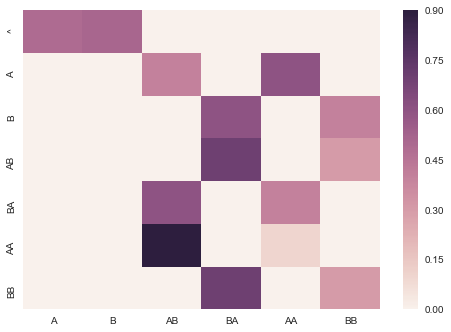

In [84]:
sns.heatmap(transition.T)

In [89]:
def generate_sequence(transition, length):
    seq = []
    for i in range(length):
        if i == 0:
            state = '^'
        elif i == 1:
            state = seq[0]
        else:
            state = ''.join(seq[(i-2):i])
        probas = transition.ix[state]
        probas = probas[probas>0]
        if rand() < probas.max():
            seq.append(probas.idxmax()[-1])
        else:
            
            seq.append(probas.idxmin()[-1])
                
    return seq

In [90]:
def generate_df(sequence, centers, dim=3):
    states = transition.columns
    rnd_data = randn(len(sequence), dim)
    df = pd.DataFrame(index=range(len(sequence)), columns=range(dim))
    for i in range(len(sequence)):
        if i == 0:
            state = sequence[0]
        else:
            state = ''.join(sequence[(i-1):(i+1)])
        df.ix[i] = array(rnd_data[i]) + array(centers[state])
    df['symbol'] = sequence
    return df

In [91]:
dim = 3
centers = {state: rand(dim)*5 for state in transition.index}

sequences = [generate_df(generate_sequence(transition.T, randint(10,30)), centers, dim) for i in range(100)]
for i, seq in enumerate(sequences):
    seq['seq_id'] = i

In [92]:
df = pd.concat(sequences)

In [93]:
df.head()

,0,1,2,symbol,seq_id
0,2.97222,4.80798,3.94992,B,0
1,0.565884,1.75121,0.396881,A,0
2,2.19778,1.55975,3.97495,A,0
3,5.07447,1.51725,4.80152,B,0
4,1.12441,2.05975,5.39223,B,0


In [94]:
model = mc.MarkovChainModel(DecisionTreeClassifier(), target_label='symbol', sequence_split_label='seq_id', max_state_length=2)

In [95]:
model.fit(df)

MarkovChainModel(base_estimator=CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            cv=3, method='sigmoid'),
         max_state_length=None, min_support=None,
         sequence_split_label='seq_id', target_label='symbol')

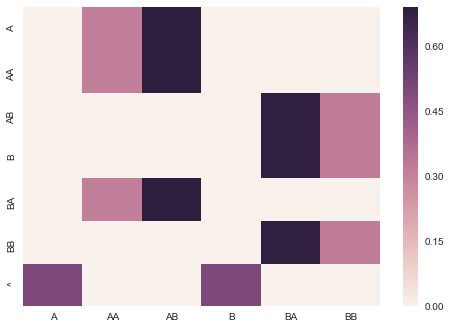

In [96]:
sns.heatmap(model.trainsition_matrix.T)

In [97]:
model.trainsition_matrix.T

,A,AA,AB,B,BA,BB
A,0.0,0.31,0.69,0.0,0.00,0.00
AA,0.0,0.31,0.69,0.0,0.00,0.00
AB,0.0,0.00,0.00,0.0,0.68,0.32
B,0.0,0.00,0.00,0.0,0.68,0.32
BA,0.0,0.31,0.69,0.0,0.00,0.00
BB,0.0,0.00,0.00,0.0,0.68,0.32
^,0.5,0.00,0.00,0.5,0.00,0.00


In [98]:
transition.T

,A,B,AB,BA,AA,BB
^,0.49,0.51,0.0,0.0,0.0,0.0
A,0.00,0.00,0.4,0.0,0.6,0.0
B,0.00,0.00,0.0,0.6,0.0,0.4
AB,0.00,0.00,0.0,0.7,0.0,0.3
BA,0.00,0.00,0.6,0.0,0.4,0.0
AA,0.00,0.00,0.9,0.0,0.1,0.0
BB,0.00,0.00,0.0,0.7,0.0,0.3


In [101]:
print(model.suffix_tree.render())

SuffixTree('/root', count=1934)
├── Node('/root/B', count=973)
│   ├── Node('/root/B/BB', count=296)
│   └── Node('/root/B/AB', count=628)
└── Node('/root/A', count=961)
    ├── Node('/root/A/BA', count=622)
    └── Node('/root/A/AA', count=288)


In [ ]:
# distance between matrices